<a href="https://colab.research.google.com/github/Jahnvi99/Leuphana-Intern/blob/master/2dGP_UCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpytorch

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from scipy.integrate import quad
import numpy as np
from scipy.integrate import simps
from numpy import trapz
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
x_0 = torch.linspace(-3, 3, 25).float()
x_1 = torch.linspace(-3, 3, 25).float()
xx, yy = torch.meshgrid(x_0, x_1) 

In [ ]:
xx.shape

torch.Size([25, 25])

In [ ]:
def gaussian_2d(X):
  return torch.tensor(multivariate_normal.pdf(X, mean = [0,0])).float()
X = torch.stack((xx.ravel(), yy.ravel())).T
X.shape

torch.Size([625, 2])

In [ ]:
Y = gaussian_2d(X)
Y.shape

torch.Size([625])

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    
    def __init__(self, train_x, train_y, likelihood, use_ard = True):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        ard_num_dims = None
        if use_ard:
            ard_num_dims = train_x.shape[-1]
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = train_x.shape[-1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [ ]:
x_sample_0 = torch.tensor(np.random.uniform(-3,3,2)).float()
x_sample_1 = torch.tensor(np.random.uniform(-3,3,2)).float()
sample_xx, sample_yy = torch.meshgrid(x_sample_0, x_sample_1) 
X_sample = torch.stack((sample_xx.ravel(), sample_yy.ravel())).T

In [ ]:
x_sample_0

tensor([ 2.3486, -1.6099])

In [ ]:
x_sample_1

tensor([ 0.4825, -2.9736])

In [ ]:
X_sample.shape

torch.Size([4, 2])

In [ ]:
Y_sample = gaussian_2d(X_sample)

In [ ]:
Y_sample.dtype

torch.float32

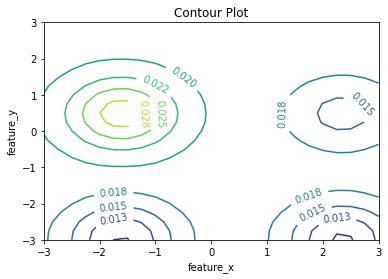

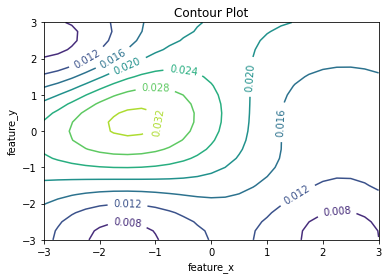

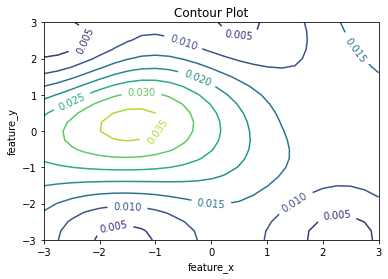

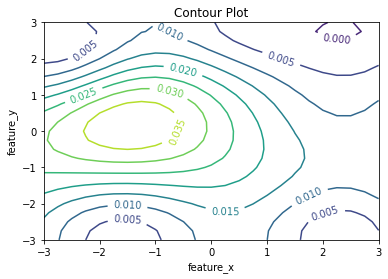

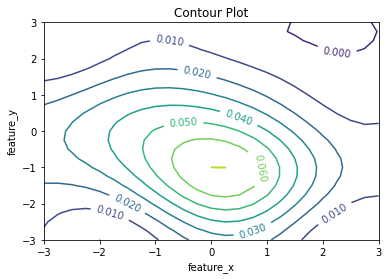

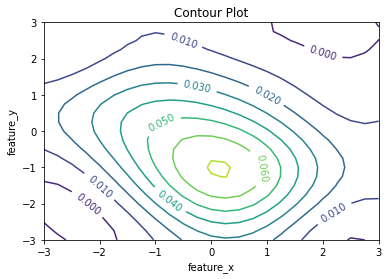

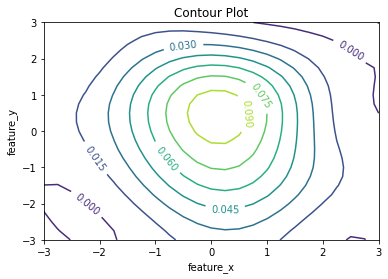

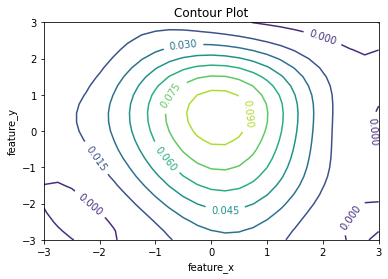

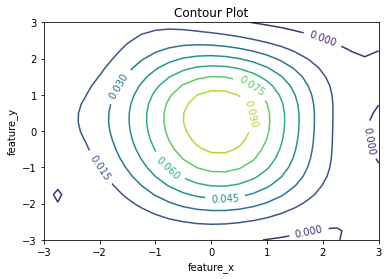

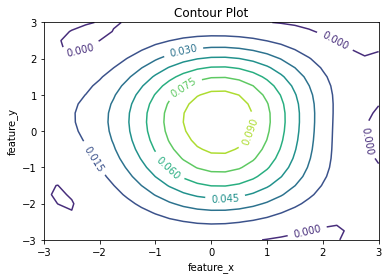

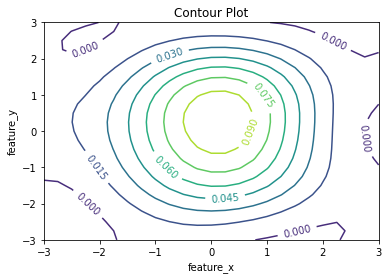

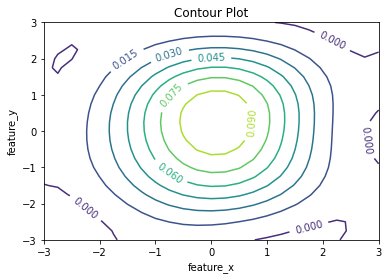

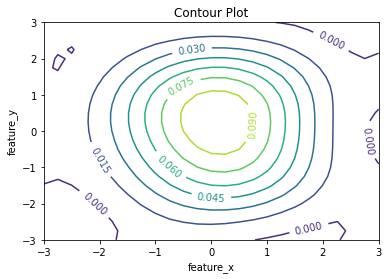

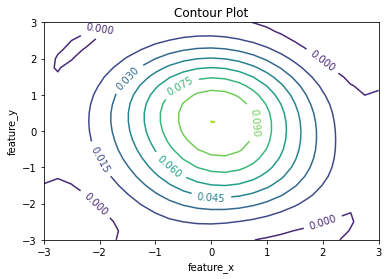

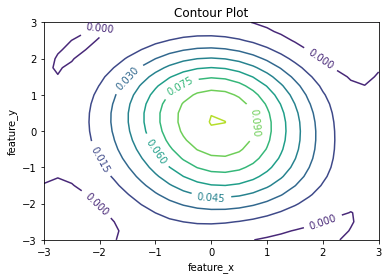

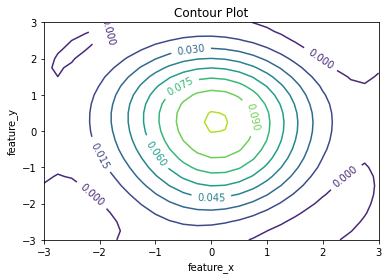

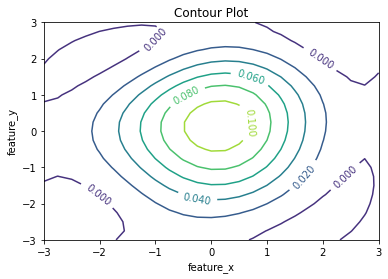

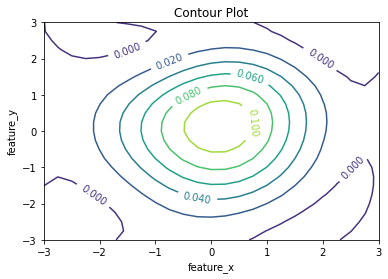

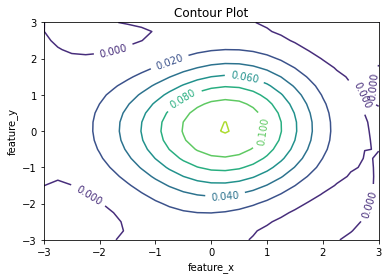

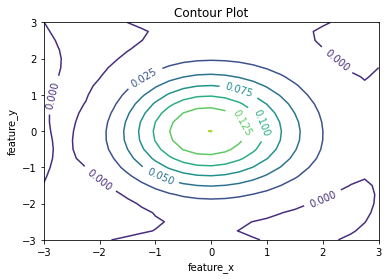

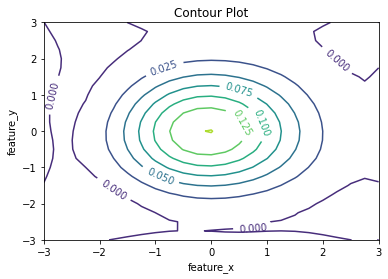

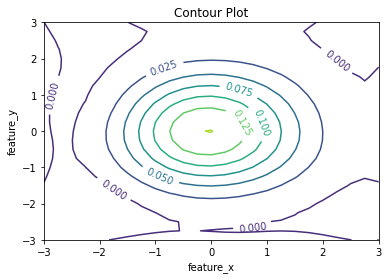

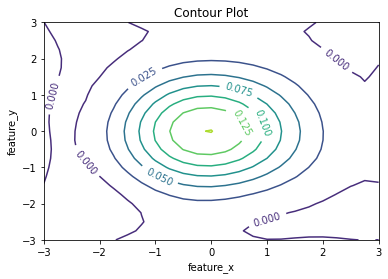

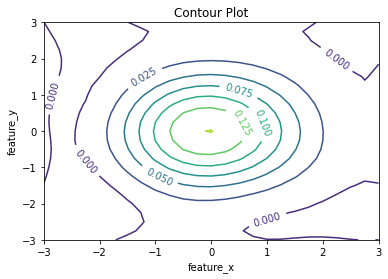

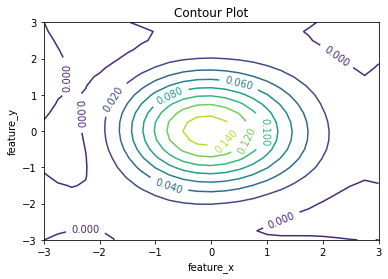

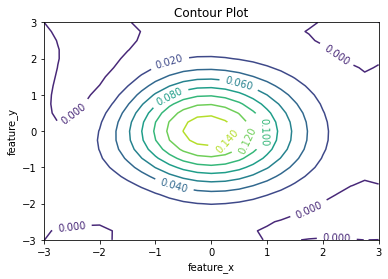

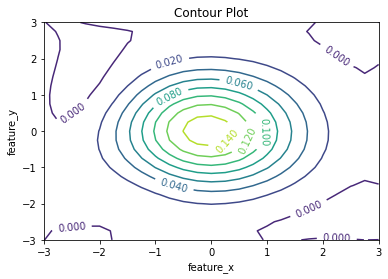

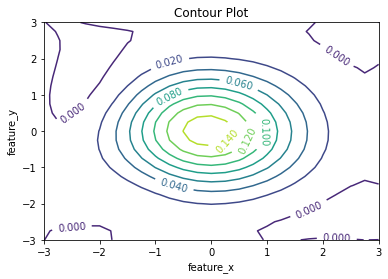

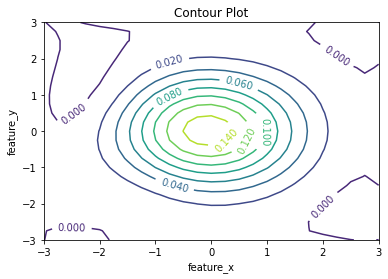

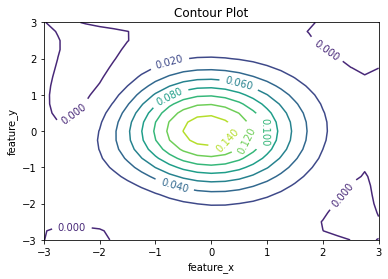

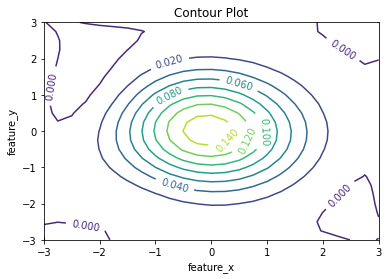

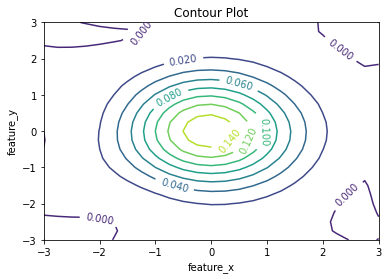

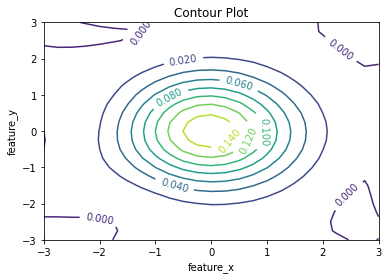

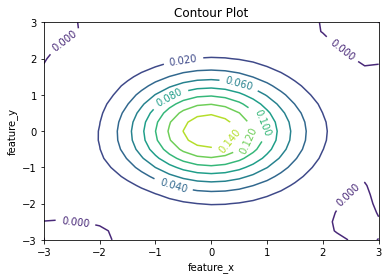

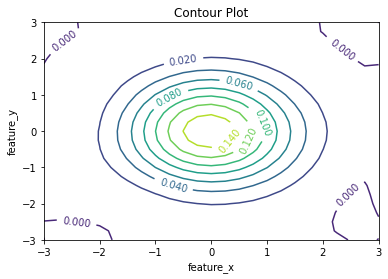

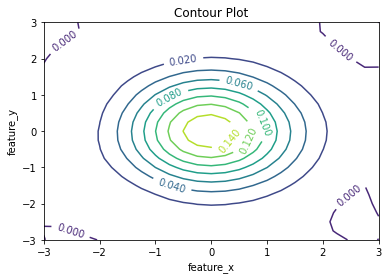

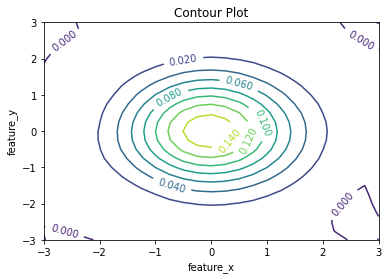

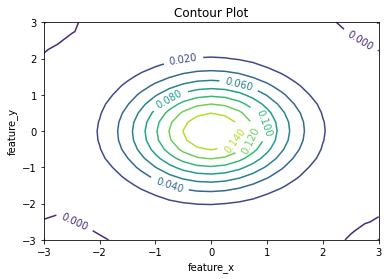

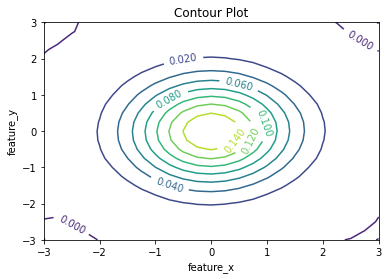

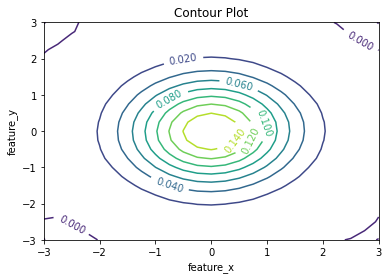

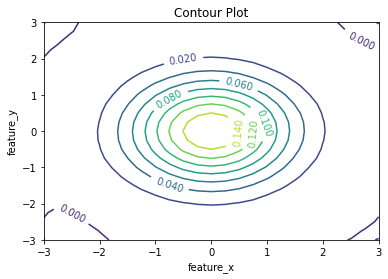

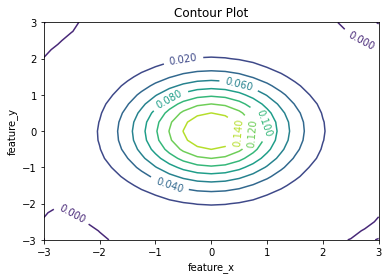

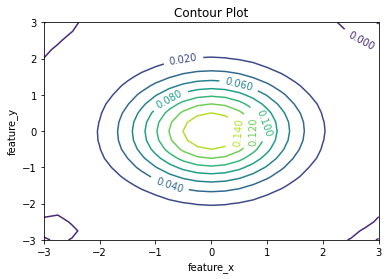

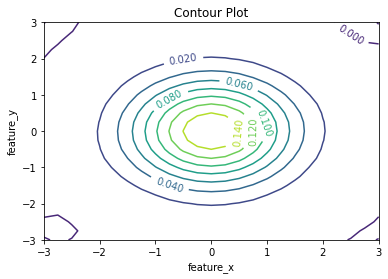

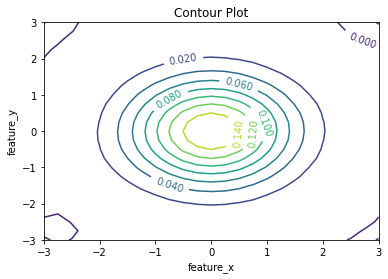

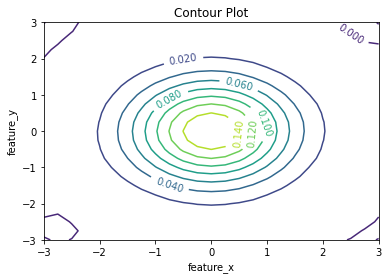

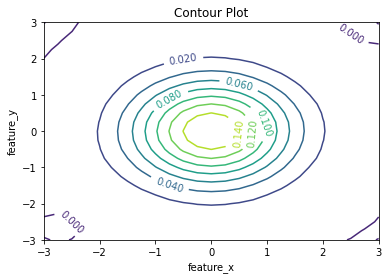

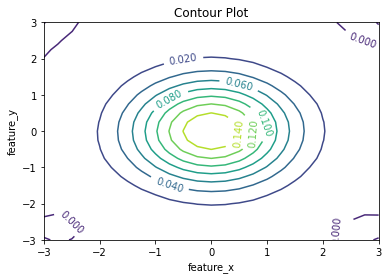

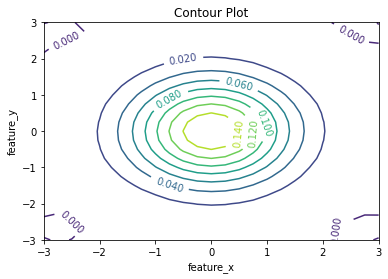

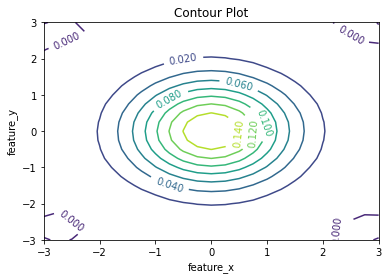

In [ ]:
for i in range(50):
  model = ExactGPModel(X_sample, Y_sample, likelihood)
  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(10):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_sample)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_sample)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X
    observed_pred = likelihood(model(test_x))
    pred_y = observed_pred.mean.reshape(xx.shape)
    fig, ax = plt.subplots(1, 1)
    # plots contour lines
    CS = ax.contour(xx, yy, pred_y)
    ax.set_title('Contour Plot')
    ax.set_xlabel('feature_x')
    ax.set_ylabel('feature_y')
    plt.clabel(CS, inline=1, fontsize=10)  
    plt.show()
  mu = observed_pred.mean
  sigma = torch.sqrt(observed_pred.variance)
  idx = torch.argmax(mu + sigma * math.sqrt(25))
  p = torch.unsqueeze(X[idx], 0)
  X_sample = torch.cat((X_sample, p))
  Y_sample = gaussian_2d(X_sample)

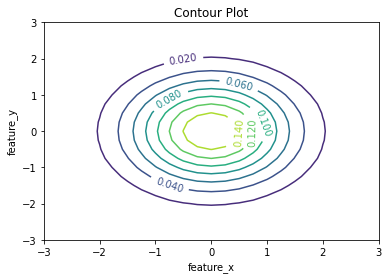

In [ ]:
Y = Y.reshape(xx.shape)
fig, ax = plt.subplots(1, 1)
  
# plots contour lines
CS = ax.contour(xx, yy, Y)
  
ax.set_title('Contour Plot')
ax.set_xlabel('feature_x')
ax.set_ylabel('feature_y')
plt.clabel(CS, inline=1, fontsize=10)  
plt.show()